In [39]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d

#compare
p0 = 101325
T0 = 300 #paper
phi = 0.7
alpha = 0.6 #paper>0.6~0.8
width = 0.02 #2cm
loglevel = 0

xh2 = alpha / (1 - alpha) * 1
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

gas = ct.Solution('gri30.yaml')
gas.TP = T0, p0
gas.set_equivalence_ratio(phi, fuel, oxidizer)

In [40]:
flame = ct.FreeFlame(gas, width=width)
flame.solve(loglevel, auto=True)
flame_speed = flame.velocity[0] #Sl0
print(f'Flame speed: {flame_speed:.5f} m/s')

Flame speed: 0.34056 m/s


In [4]:
# get adiabatic temperature from the FreeFlame object
def get_adiabatic_temperature_from_flame(flame): # lamninar unstretched flame
    Tad = flame.T[-1]  # final status of the flame
    return Tad

Tad = get_adiabatic_temperature_from_flame(flame)   ## (Viken) adiabatic temperature should be from the laminar unstretched configuration
print(f'Adiabatic temperature (Tad) from FreeFlame: {Tad:.2f} K')
Xflame = flame.X[:,-1] ## (viken)
#print(Xflame)

### (viken) use laminar flame to compute the thermal diffusivity, only needed once per operating conditions
cp      = flame.cp_mass[0]
density = flame.density_mass[0]    
lambda_     = flame.thermal_conductivity[0]
thermal_diffusivity = lambda_ / (density * cp)

Adiabatic temperature (Tad) from FreeFlame: 1820.61 K


In [5]:
def calculate_heat_loss_coefficient(Tp, Tad, Tr):
    beta = (Tp - Tr) / (Tad - Tr)
    return beta

In [6]:
def calculate_consumption_speed(flame_cf, gas, fuel_species):
    rho_u = flame_cf.density[0]
    total_fuel_mass_fraction = sum(flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)

    integral_numerator = 0
    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)
        nk = flame_cf.Y[i_fuel, 0] / total_fuel_mass_fraction
        integral = scipy.integrate.simpson(gas.molecular_weights[i_fuel] * flame_cf.net_production_rates[i_fuel], x=flame_cf.grid)
        integral_numerator += nk * integral

    mass_fraction_diff = sum(flame_cf.Y[gas.species_index(fuel), -1] - flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)
    S_cF = integral_numerator / (rho_u * mass_fraction_diff)
    return S_cF

In [55]:
mdot_values = np.logspace(-2, 2, 50)  # From 0.01 to 100 with 50 points
Ka_values = []
ScF_values = []

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf.transport_model = 'multicomponent'
    flame_cf.energy_enabled = True
    flame.soret_enabled = True
    flame_cf.set_refine_criteria(ratio=2, slope=0.05, curve=0.1, prune=0.01)
    flame_cf.reactants.mdot = mdot
    flame_cf.products.mdot = mdot
    flame_cf.products.T = Tad  ## no heat loss
    flame_cf.products.X = Xflame
    flame_cf.set_initial_guess(equilibrate=False)
    
    flame_cf.solve(loglevel, auto=True)

    # Update temperature for current mdot
    Tp = Tad #revise
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf.velocity, flame_cf.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value
    Ka_values.append(Ka)
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF_values.append(ScF)
    print(ScF)

0.01 . 0.01582000386815461
0.012067926406393288 . 0.01805844748905383
0.014563484775012436 . 0.020751281910393455
0.017575106248547922 . 0.023964623041164347
0.021209508879201904 . 0.027792835142057916
0.025595479226995357 . 0.03236209238814181
0.030888435964774818 . 0.037787882181576846
0.0372759372031494 . 0.04418431817009356
0.04498432668969444 . 0.05171110299805835
0.054286754393238594 . 0.06070569383339915
0.0655128556859551 . 0.07094695221914969
0.07906043210907697 . 0.0827734266101652
0.09540954763499938 . 0.09636146408651287
0.1151395399326447 . 0.11194809812173298
0.13894954943731375 . 0.12976711341427571
0.16768329368110074 . 0.1500372405301419
0.20235896477251566 . 0.1735250217003956
0.2442053094548651 . 0.19951251102781703
0.29470517025518095 . 0.22788259095875107
0.35564803062231287 . 0.2580345448884295
0.42919342601287763 . 0.26744220405324287
0.517947467923121 . 0.2700310260104859
0.6250551925273969 . 0.27287554571991823
0.7543120063354615 . 0.2752512988155447
0.91029817

In [59]:
y_values = []
for i in ScF_values:
    temp = i / flame_speed
    y_values.append(temp)

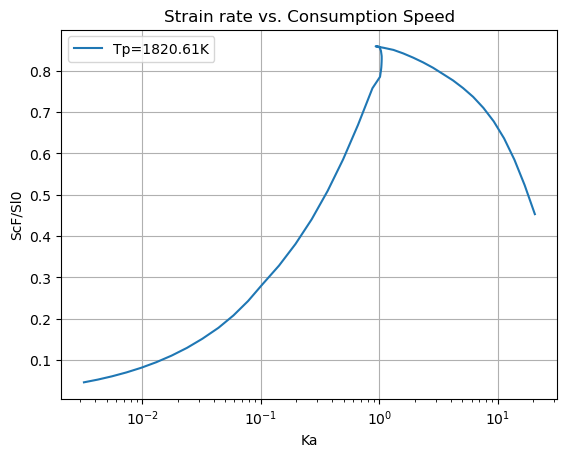

In [63]:
plt.plot(Ka_values, y_values, label='Tp=1820.61K') #compare
plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Ka')
plt.ylabel('ScF/Sl0')
plt.title('Strain rate vs. Consumption Speed')
plt.grid(True)
plt.show()

In [132]:
Tp = [300, 453, 605, 757, 909, 1061, 1213, 1365, 1517, 1670, 1820.61]
for temp in Tp:
    beta = calculate_heat_loss_coefficient(temp, Tad, T0)
    print(beta)

0.0
0.10061756340270997
0.2005774956720689
0.30053742794142785
0.40049736021078675
0.5004572924801457
0.6004172247495047
0.7003771570188635
0.8003370892882224
0.9009546526909324
1.0000004776849334


In [28]:
y_values = []
for i in ScF_values:
    temp = i / flame_speed
    y_values.append(temp)
print(y_values)

[0.09321532231403255, 0.1658576370182114, 0.23277638775566944, 0.29380282889055714, 0.6776127990694594, 0.8589549626713995, 0.7859569518369143, 0.7064172328856381, 0.6229827244759614]


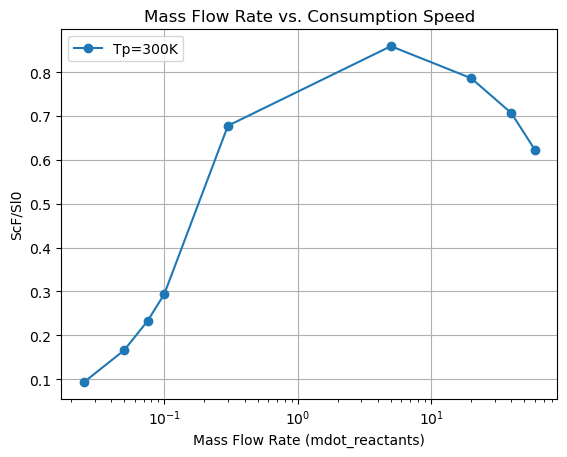

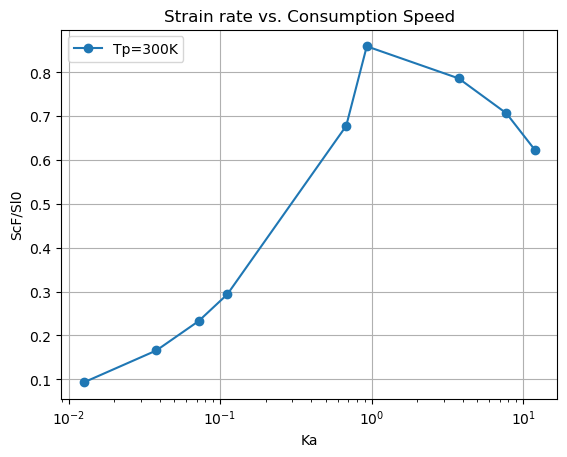

In [29]:
plt.plot(mdot_values, y_values, marker='o', label='Tp=300K')
plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('ScF/Sl0')
plt.title('Mass Flow Rate vs. Consumption Speed')
plt.grid(True)
plt.show()

plt.plot(Ka_values, y_values, marker='o', label='Tp=300K')
plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Ka')
plt.ylabel('ScF/Sl0')
plt.title('Strain rate vs. Consumption Speed')
plt.grid(True)
plt.show()

In [41]:
Tp_values = [300, 453, 605, 757, 909, 1061, 1213, 1365, 1517, 1670, 1820.61]
mdot_values = [0.025, 0.05, 0.075, 0.1, 0.3, 5, 20, 40, 60]
Ka_values = []
ScF_values = []

# Loop through Tp values
for Tp in Tp_values:
    ScF_row = []
    for mdot in mdot_values:
        # Initialize gas object in each iteration to avoid carrying over previous states
        gas = ct.Solution('gri30.yaml')
        gas.TP = T0, p0
        gas.set_equivalence_ratio(phi, fuel, oxidizer)

        flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
        flame_cf.transport_model = 'multicomponent'
        flame_cf.energy_enabled = True
        flame_cf.soret_enabled = True
        #flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
        flame_cf.set_refine_criteria(ratio=2, slope=0.05, curve=0.1, prune=0.01)
        flame_cf.reactants.mdot = mdot
        flame_cf.products.mdot = mdot
        flame_cf.products.T = Tp  # no heat loss
        flame_cf.products.X = Xflame  # (viken)
        flame_cf.set_initial_guess(equilibrate=False)
        
        flame_cf.solve(loglevel, auto=True)

        # Calculate the maximum gradient |du/dx|
        grad_u = np.gradient(flame_cf.velocity, flame_cf.grid)
        max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
        max_grad_value = np.abs(grad_u[max_grad_idx])  # Ensure positive value for Ka calculation

        # Calculate strain rate (Ka)
        Ka = (thermal_diffusivity / flame_speed) / flame_speed * max_grad_value
        Ka_values.append(Ka)

        # Calculate ScF
        ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
        ScF_row.append(ScF)
    ScF_values.append(ScF_row)
#print(ScF_values)

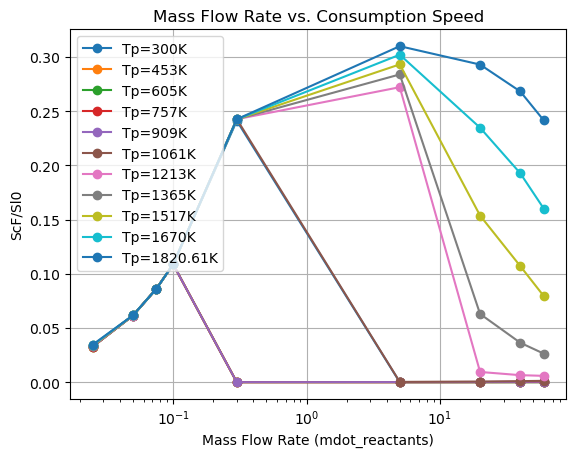

In [44]:
for i, ScF_row in enumerate(ScF_values):
    Tp = Tp_values[i]
    plt.plot(mdot_values, ScF_row, marker='o', label=f'Tp={Tp}K')

plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('ScF/Sl0')
plt.title('Mass Flow Rate vs. Consumption Speed')
plt.grid(True)
plt.show()

In [ ]:
for i, ScF_row in enumerate(ScF_values):
    Tp = Tp_values[i]
    Ka_row = Ka_values[i * len(mdot_values):(i + 1) * len(mdot_values)]  # Tp에 해당하는 Ka_values 가져오기
    plt.plot(Ka_row, ScF_row, marker='o', label=f'Tp={Tp}K')

plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Strain Rate (Ka)')
plt.ylabel('ScF/Sl0')
plt.title('Strain Rate vs. Consumption Speed')
plt.grid(True)
plt.show()

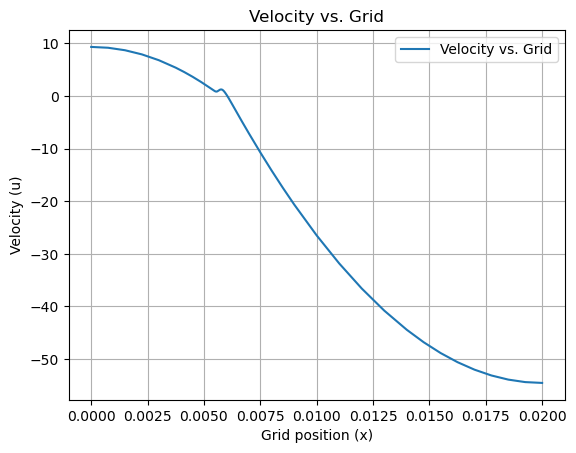

In [17]:
# plot grid-velocity graph
plt.plot(flame_cf.grid, flame_cf.velocity, label='Velocity vs. Grid')
plt.xlabel('Grid position (x)')
plt.ylabel('Velocity (u)')
plt.title('Velocity vs. Grid')
plt.legend()
plt.grid(True)
plt.show()